In [1]:
%load_ext Cython
import numpy as np
ň = np.newaxis
from scipy.constants import epsilon_0 as ε_0, c, pi as π, e, hbar as ℏ, mu_0 as μ_0
eV = e
from scipy.special import lpmn, lpmv, sph_jn, sph_yn, poch
from scipy.misc import factorial
import math
import cmath

In [2]:
%%cython
# cythonized functions here
cimport numpy as np
import numpy as np
cimport cython

## Auxillary function for retrieving the "meshgrid-like" indices; inc. nmax
@cython.boundscheck(False)
def get_mn_y(int nmax):
    """
    Auxillary function for retreiving the 'meshgrid-like' indices from the flat indexing; 
    inc. nmax.
    ('y to mn' conversion)
    
    Parameters
    ----------

    nmax : int
        The maximum order to which the VSWFs / Legendre functions etc. will be evaluated.
        
    Returns
    -------
    
    output : (m, n)
        Tuple of two arrays of type np.array(shape=(nmax*nmax + 2*nmax), dtype=np.int),
        where [(m[y],n[y]) for y in range(nmax*nmax + 2*nma)] covers all possible 
        integer pairs n >= 1, -n <= m <= n.
    """
    cdef Py_ssize_t nelems = nmax * nmax + 2 * nmax
    cdef np.ndarray[np.int_t,ndim=1] m_arr = np.empty([nelems], dtype=np.int)
    cdef np.ndarray[np.int_t,ndim=1] n_arr = np.empty([nelems], dtype=np.int)
    cdef Py_ssize_t i = 0
    cdef np.int_t n, m
    for n in range(1,nmax+1):
        for m in range(-n,n+1):
            m_arr[i] = m
            n_arr[i] = n
            i = i + 1
    return (m_arr, n_arr)

def get_y_mn_unsigned(int nmax): 
    """
    Auxillary function for mapping 'unsigned m', n indices to the flat y-indexing.
    For use with functions as scipy.special.lpmn, which have to be evaluated separately
    for positive and negative m.
    
    Parameters
    ----------

    nmax : int
        The maximum order to which the VSWFs / Legendre functions etc. will be evaluated.
        
    output : (ymn_plus, ymn_minus)
        Tuple of two arrays of shape (nmax+1,nmax+1), containing the flat y-indices corresponding
        to the respective (m,n) and (-m,n). The elements for which |m| > n are set to -1.
        (Therefore, the caller must not use those elements equal to -1.)
    """
    cdef np.ndarray[np.intp_t, ndim=2] ymn_plus = np.full((nmax+1,nmax+1),-1, dtype=np.intp)
    cdef np.ndarray[np.intp_t, ndim=2] ymn_minus = np.full((nmax+1,nmax+1),-1, dtype=np.intp)
    cdef Py_ssize_t i = 0
    cdef np.int_t n, m
    for n in range(1,nmax+1):
        for m in range(-n,0):
            ymn_minus[-m,n] = i
            i = i + 1
        for m in range(0,n+1):
            ymn_plus[m,n] = i
            i = i + 1
    return(ymn_plus, ymn_minus)

In [3]:
# Coordinate transforms for arrays of "arbitrary" shape
def cart2sph(cart,axis=-1):
    if (cart.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [x, y, z] = np.split(cart,3,axis=axis)
    r = np.linalg.norm(cart,axis=axis,keepdims=True)
    r_zero = np.logical_not(r)
    θ = np.arccos(z/(r+r_zero))
    φ = np.arctan2(y,x) # arctan2 handles zeroes correctly itself
    return np.concatenate((r,θ,φ),axis=axis)

def sph2cart(sph, axis=-1):
    if (sph.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [r,θ,φ] = np.split(sph,3,axis=axis)
    sinθ = np.sin(θ)
    x = r * sinθ * np.cos(φ)
    y = r * sinθ * np.sin(φ)
    z = r * np.cos(θ)
    return np.concatenate((x,y,z),axis=axis)

def sph_loccart2cart(loccart, sph, axis=-1):
    """
    Transformation of vector specified in local orthogonal coordinates 
    (tangential to spherical coordinates – basis r̂,θ̂,φ̂) to global cartesian
    coordinates (basis x̂,ŷ,ẑ)
    SLOW FOR SMALL ARRAYS
    
    Parameters
    ----------
    loccart: ... TODO
        the transformed vector in the local orthogonal coordinates
        
    sph: ... TODO
        the point (in spherical coordinates) at which the locally
        orthogonal basis is evaluated
        
    Returns
    -------
    output: ... TODO
        The coordinates of the vector in global cartesian coordinates
    """
    if (loccart.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [r,θ,φ] = np.split(sph,3,axis=axis)
    sinθ = np.sin(θ)
    cosθ = np.cos(θ)
    sinφ = np.sin(φ)
    cosφ = np.cos(φ)
    
    #x = r * sinθ * cosφ
    #y = r * sinθ * sinφ
    #z = r * cosθ
    r̂x = sinθ * cosφ
    r̂y = sinθ * sinφ
    r̂z = cosθ
    θ̂x = cosθ * cosφ
    θ̂y = cosθ * sinφ
    θ̂z = -sinθ
    φ̂x = -sinφ
    φ̂y = cosφ
    φ̂z = np.zeros(φ̂y.shape)
    r̂ = np.concatenate((r̂x,r̂y,r̂z),axis=axis)
    θ̂ = np.concatenate((θ̂x,θ̂y,θ̂z),axis=axis)
    φ̂ = np.concatenate((φ̂x,φ̂y,φ̂z),axis=axis)
    [inr̂,inθ̂,inφ̂] = np.split(loccart,3,axis=axis)
    out=inr̂*r̂+inθ̂*θ̂+inφ̂*φ̂
    return out


def lpy(nmax, z):
    """
    Associated legendre function and its derivatative at z in the 'y-indexing'.
    (Without Condon-Shortley phase AFAIK.)
    NOT THOROUGHLY TESTED
    
    Parameters
    ----------
    
    nmax: int
        The maximum order to which the Legendre functions will be evaluated..
        
    z: float
        The point at which the Legendre functions are evaluated.
        
    output: (P_y, dP_y) TODO
        y-indexed legendre polynomials and their derivatives
    
    """
    pmn_plus, dpmn_plus = lpmn(nmax, nmax, z)
    pmn_minus, dpmn_minus = lpmn(-nmax, nmax, z)
    nelem = nmax * nmax + 2*nmax
    P_y = np.empty((nelem), dtype=np.float_)
    dP_y = np.empty((nelem), dtype=np.float_)
    mn_p_y, mn_n_y = get_y_mn_unsigned(nmax)
    mn_plus_mask = (mn_p_y >= 0)
    mn_minus_mask = (mn_n_y >= 0)
    #print( mn_n_y[mn_minus_mask])
    P_y[mn_p_y[mn_plus_mask]] = pmn_plus[mn_plus_mask]
    P_y[mn_n_y[mn_minus_mask]] = pmn_minus[mn_minus_mask]
    dP_y[mn_p_y[mn_plus_mask]] = dpmn_plus[mn_plus_mask]
    dP_y[mn_n_y[mn_minus_mask]] = dpmn_minus[mn_minus_mask]
    return (P_y, dP_y)

def vswf_yr(pos_sph,nmax,J=1):
    """
    Normalized vector spherical wavefunctions $\widetilde{M}_{mn}^{j}$,
    $\widetilde{N}_{mn}^{j}$ as in [1, (2.40)].
    
    Parameters
    ----------
    
    pos_sph : np.array(dtype=float, shape=(someshape,3))
        The positions where the spherical vector waves are to be
        evaluated. The last axis corresponds to the individual
        points (r,θ,φ). The radial coordinate r is dimensionless,
        assuming that it has already been multiplied by the
        wavenumber.
    
    nmax : int
        The maximum order to which the VSWFs are evaluated.
        
    Returns
    -------
    
    output : np.array(dtype=complex, shape=(someshape,nmax*nmax + 2*nmax,3))
        Spherical vector wave functions evaluated at pos_sph,
        in the local basis (r̂,θ̂,φ̂). The last indices correspond
        to m, n (in the ordering given by mnindex()), and basis 
        vector index, respectively.
        
    [1] Jonathan M. Taylor. Optical Binding Phenomena: Observations and
    Mechanisms.
    """
    #mi, ni = mnindex(nmax)
    #nelems = nmax*nmax + 2*nmax
    ## TODO Remove these two lines in production:
    #if(len(mi) != nelems):
    #    raise ValueError("This is very wrong.")
    ## Pre-calculate the associated Legendre function
    #Prmn, dPrmn = lpmn(nmax,nmax,)
    ## Normalized funs π̃, τ̃
    #π̃ = 
    pass

from scipy.special import sph_jn, sph_yn
def _sph_zn_1(n,z):
    return sph_jn(n,z)
def _sph_zn_2(n,z):
    return sph_yn(n,z)
def _sph_zn_3(n,z):
    besj=sph_jn(n,z)
    besy=sph_yn(n,z)
    return (besj[0] + 1j*besy[0],besj[1] + 1j*besy[1])
def _sph_zn_4(n,z):
    besj=sph_jn(n,z)
    besy=sph_yn(n,z)
    return (besj[0] - 1j*besy[0],besj[1] - 1j*besy[1])
_sph_zn = [_sph_zn_1,_sph_zn_2,_sph_zn_3,_sph_zn_4]

# computes bessel/hankel functions for orders from 0 up to n; drops
# the derivatives which are also included in scipy.special.sph_jn/yn
def zJn(n, z, J=1):
    return _sph_zn[J-1](n=n,z=z)



# The following 4 funs have to be refactored, possibly merged
def π̃_zerolim(nmax): # seems OK
    """
    lim_{θ→ 0-} π̃(cos θ)
    """
    my, ny = get_mn_y(nmax)
    nelems = len(my)
    π̃_y = np.zeros((nelems))
    plus1mmask = (my == 1)
    minus1mmask = (my == -1)
    pluslim = -ny*(1+ny)/2
    minuslim = 0.5
    π̃_y[plus1mmask] = pluslim[plus1mmask]
    π̃_y[minus1mmask] = - minuslim
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    π̃_y = prenorm *     π̃_y
    return π̃_y

def π̃_pilim(nmax): # Taky OK, jen to možná není kompatibilní se vzorečky z mathematiky
    """
    lim_{θ→ π+} π̃(cos θ)
    """
    my, ny = get_mn_y(nmax)
    nelems = len(my)
    π̃_y = np.zeros((nelems))
    plus1mmask = (my == 1)
    minus1mmask = (my == -1)
    pluslim = (-1)**ny*ny*(1+ny)/2
    minuslim = 0.5*(-1)**ny
    π̃_y[plus1mmask] = pluslim[plus1mmask]
    π̃_y[minus1mmask] = minuslim[minus1mmask]
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    π̃_y = prenorm *     π̃_y
    return π̃_y

def τ̃_zerolim(nmax):
    """
    lim_{θ→ 0-} τ̃(cos θ)
    """
    p0 = π̃_zerolim(nmax)
    my, ny = get_mn_y(nmax)
    minus1mmask = (my == -1)
    p0[minus1mmask] = -p0[minus1mmask]
    return p0

def τ̃_pilim(nmax):
    """
    lim_{θ→  π+} τ̃(cos θ)
    """
    t = π̃_pilim(nmax)
    my, ny = get_mn_y(nmax)
    plus1mmask = (my == 1)
    t[plus1mmask] = -t[plus1mmask]
    return t
    
def get_π̃τ̃_y1(θ,nmax):
    # TODO replace with the limit functions (below) when θ approaches
    # the extreme values at about 1e-6 distance
    """
    (... TODO)
    
    """
    if (abs(θ)<1e-6):
        return (π̃_zerolim(nmax),τ̃_zerolim(nmax))
    if (abs(θ-π)<1e-6):
        return (π̃_pilim(nmax),τ̃_pilim(nmax))
    my, ny = get_mn_y(nmax)
    nelems = len(my)
    Py, dPy = lpy(nmax, math.cos(θ))
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    π̃_y = prenorm * my * Py / math.sin(θ)  # bacha, možné dělení nulou
    τ̃_y = prenorm * dPy * (- math.sin(θ))  # TADY BACHA!!!!!!!!!! * (- math.sin(pos_sph[1])) ???
    return (π̃_y,τ̃_y)
    
def vswf_yr1(pos_sph,nmax,J=1):
    """
    As vswf_yr, but evaluated only at single position (i.e. pos_sph has
    to have shape=(3))
    """
    if (pos_sph[1].imag or pos_sph[2].imag):
        raise ValueError("The angles for the spherical wave functions can not be complex")
    kr = pos_sph[0] if pos_sph[0].imag else pos_sph[0].real # To supress the idiotic warning in scipy.special.sph_jn
    θ = pos_sph[1].real
    φ = pos_sph[2].real
    my, ny = get_mn_y(nmax)
    Py, dPy = lpy(nmax, math.cos(θ))
    nelems = nmax*nmax + 2*nmax
    # TODO Remove these two lines in production:
    if(len(Py) != nelems or len(my) != nelems):
        raise ValueError("This is very wrong.")
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    if (abs(θ)<1e-6): # Ošetření limitního chování derivací Leg. fcí
        π̃_y=π̃_zerolim(nmax)
        τ̃_y=τ̃_zerolim(nmax)
    elif (abs(θ-π)<1e-6):
        π̃_y=π̃_pilim(nmax)
        τ̃_y=τ̃_pilim(nmax)
    else:
        π̃_y = prenorm * my * Py / math.sin(θ) 
        τ̃_y = prenorm * dPy * (- math.sin(θ))  # TADY BACHA!!!!!!!!!! * (- math.sin(pos_sph[1])) ???
    z_n, dz_n = zJn(nmax, kr, J=J)
    z_y = z_n[ny]
    dz_y = dz_n[ny]
    eimf_y = np.exp(1j*my*φ) # zbytečné opakování my, lepší by bylo to spočítat jednou a vyindexovat
    M̃_y = np.zeros((nelems,3), dtype=np.complex_)
    M̃_y[:,1] = 1j * π̃_y * eimf_y * z_y
    M̃_y[:,2] =  -   τ̃_y * eimf_y * z_y
    Ñ_y = np.empty((nelems,3), dtype=np.complex_)
    Ñ_y[:,0] = (ny*(ny+1)/kr) * prenorm * Py * eimf_y * z_y
    Ñradial_fac_y = z_y / kr + dz_y
    Ñ_y[:,1] =    τ̃_y * eimf_y * Ñradial_fac_y
    Ñ_y[:,2] = 1j*π̃_y * eimf_y * Ñradial_fac_y
    return(M̃_y, Ñ_y)
    
#def plane_E_y(nmax):
#    """
#    The E_mn normalization factor as in [1, (3)] WITHOUT the E_0 factor,
#    y-indexed
#    
#    (... TODO)
#    
#    References
#    ----------
#    [1] Jonathan M. Taylor. Optical Binding Phenomena: Observations and
#    Mechanisms. FUCK, I MADE A MISTAKE: THIS IS FROM 7U
#    """
#    my, ny = get_mn_y(nmax)
#    return 1j**ny * np.sqrt((2*ny+1)*factorial(ny-my) /
#                            (ny*(ny+1)*factorial(ny+my))
#    )

def zplane_pq_y(nmax, betap = 0):
    """
    The z-propagating plane wave expansion coefficients as in [1, (1.12)]
    
    (... TODO)
    """
    my, ny = get_mn_y(nmax)
    U_y = 4*π * 1j**ny / (ny * (ny+1))
    π̃_y = π̃_zerolim(nmax)
    τ̃_y = τ̃_zerolim(nmax)
    
    # fixme co je zač ten e_θ ve vzorečku? (zde neimplementováno)
    p_y = U_y*(τ̃_y*math.cos(betap) - 1j*math.sin(betap)*π̃_y)
    q_y = U_y*(π̃_y*math.cos(betap) - 1j*math.sin(betap)*τ̃_y)
    return (p_y, q_y)
    
    
import warnings
def plane_pq_y(nmax, kdir_cart, E_cart):
    """
    The plane wave expansion coefficients for any direction kdir_cart
    and amplitude vector E_cart (which might be complex, depending on
    the phase and polarisation state). If E_cart and kdir_cart are
    not orthogonal, the result should correspond to the k-normal part
    of E_cart.
    """
    if np.iscomplexobj(kdir_cart):
        warnings.warn("The direction vector for the plane wave coefficients should be real. I am discarding the imaginary part now.")
        kdir_cart = kdir_cart.real
        
    k_sph = cart2sph(kdir_cart)
    π̃_y, τ̃_y = get_π̃τ̃_y1(k_sph[1], nmax) 
    my, ny = get_mn_y(nmax)
    U_y = 4*π * 1j**ny / (ny * (ny+1))
    θ̂ = sph_loccart2cart(np.array([0,1,0]), k_sph, axis=-1)
    φ̂ = sph_loccart2cart(np.array([0,0,1]), k_sph, axis=-1)
    p_y = np.sum( U_y[:,ň]
                  * np.conj(np.exp(1j*my[:,ň]*k_sph[2]) * (
                     θ̂[ň,:]*τ̃_y[:,ň] + 1j*φ̂[ň,:]*π̃_y[:,ň]))
                  * E_cart[ň,:],
              axis=-1)
    q_y = np.sum( U_y[:,ň]
                  * np.conj(np.exp(1j*my[:,ň]*k_sph[2]) * (
                     θ̂[ň,:]*π̃_y[:,ň] + 1j*φ̂[ň,:]*τ̃_y[:,ň]))
                  * E_cart[ň,:],
          axis=-1)
    return (p_y, q_y)
    

In [4]:
# Functions copied from scattering_xu, additionaly normalized
from py_gmm.gmm import vec_trans as vc

def q_max(m,n,μ,ν):
    return min(n,ν,(n+ν-abs(m+μ))/2)
    
# returns array with indices corresponding to q
# argument q does nothing for now
def a_q(m,n,μ,ν,q = None):
    qm=q_max(m,n,μ,ν)
    res, err= vc.gaunt_xu(m,n,μ,ν,qm)
    if(err):
        print("m,n,μ,ν,qm = ",m,n,μ,ν,qm)
        raise ValueError('Something bad in the fortran subroutine gaunt_xu happened')
    return res

# All arguments are single numbers (for now)
# ZDE VYCHÁZEJÍ DIVNÁ ZNAMÉNKA
def Ã(m,n,μ,ν,kdlj,θlj,φlj,r_ge_d,J):
    exponent=(math.lgamma(2*n+1)-math.lgamma(n+2)+math.lgamma(2*ν+3)-math.lgamma(ν+2) 
                +math.lgamma(n+ν+m-μ+1)-math.lgamma(n-m+1)-math.lgamma(ν+μ+1)
                +math.lgamma(n+ν+1) - math.lgamma(2*(n+ν)+1))
    presum = math.exp(exponent)
    presum = presum * np.exp(1j*(μ-m)*φlj) * (-1)**m * 1j**(ν+n) / (4*n)
    qmax = math.floor(q_max(-m,n,μ,ν)) #nemá tu být +m?
    q = np.arange(qmax+1, dtype=int)
    # N.B. -m !!!!!!
    a1q = a_q(-m,n,μ,ν) # there is redundant calc. of qmax
    ã1q = a1q / a1q[0]
    p = n+ν-2*q
    if(r_ge_d):
        J = 1
    zp = zJn(n+ν,kdlj,J)[0][p]
    Pp = lpmv(μ-m,p,math.cos(θlj))
    summandq = (n*(n+1) + ν*(ν+1) - p*(p+1)) * (-1)**q * ã1q * zp * Pp
  
    # Taylor normalisation v2, proven to be equivalent (NS which is better)
    prenormratio = 1j**(ν-n) * math.sqrt(((2*ν+1)/(2*n+1))* math.exp(
        math.lgamma(n+m+1)-math.lgamma(n-m+1)+math.lgamma(ν-μ+1)-math.lgamma(ν+μ+1)))
    presum = presum / prenormratio
    
    # Taylor normalisation
    #prenormmn =  math.sqrt((2*n + 1)*math.factorial(n-m)/(4*π*factorial(n+m)))
    #prenormμν =  math.sqrt((2*ν + 1)*math.factorial(ν-μ)/(4*π*factorial(ν+μ)))
    #presum = presum * prenormμν / prenormmn
    
    return presum * np.sum(summandq)
    
# ZDE OPĚT JINAK ZNAMÉNKA než v Xu (J. comp. phys 127, 285)
def B̃(m,n,μ,ν,kdlj,θlj,φlj,r_ge_d,J):
    exponent=(math.lgamma(2*n+3)-math.lgamma(n+2)+math.lgamma(2*ν+3)-math.lgamma(ν+2) 
                +math.lgamma(n+ν+m-μ+2)-math.lgamma(n-m+1)-math.lgamma(ν+μ+1)
                +math.lgamma(n+ν+2) - math.lgamma(2*(n+ν)+3))
    presum = math.exp(exponent)
    presum = presum * np.exp(1j*(μ-m)*φlj) * (-1)**m * 1j**(ν+n+1) / (
        (4*n)*(n+1)*(n+m+1))
    Qmax = math.floor(q_max(-m,n+1,μ,ν))
    q = np.arange(Qmax+1, dtype=int)
    if (μ == ν): # it would disappear in the sum because of the factor (ν-μ) anyway
        ã2q = 0
    else:
        a2q = a_q(-m-1,n+1,μ+1,ν)
        ã2q = a2q / a2q[0]
    a3q = a_q(-m,n+1,μ,ν)
    ã3q = a3q / a3q[0]
    p = n+ν-2*q
    if(r_ge_d):
        J = 1
    zp_ = zJn(n+1+ν,kdlj,J)[0][p+1] # je ta +1 správně?
    Pp_ = lpmv(μ-m,p+1,math.cos(θlj))
    summandq = ((2*(n+1)*(ν-μ)*ã2q
                 -(-ν*(ν+1) - n*(n+3) - 2*μ*(n+1)+p*(p+3))* ã3q)
                *(-1)**q * zp_ * Pp_)
    
    # Taylor normalisation v2, proven to be equivalent
    prenormratio = 1j**(ν-n) * math.sqrt(((2*ν+1)/(2*n+1))* math.exp(
        math.lgamma(n+m+1)-math.lgamma(n-m+1)+math.lgamma(ν-μ+1)-math.lgamma(ν+μ+1)))
    presum = presum / prenormratio
    
    ## Taylor normalisation
    #prenormmn =  math.sqrt((2*n + 1)*math.factorial(n-m)/(4*π*factorial(n+m)))
    #prenormμν =  math.sqrt((2*ν + 1)*math.factorial(ν-μ)/(4*π*factorial(ν+μ)))
    #presum = presum * prenormμν / prenormmn
    
    return presum * np.sum(summandq)
 

In [5]:
# Material parameters
def ε_drude(ε_inf, ω_p, γ_p, ω): # RELATIVE permittivity, of course
    return ε_inf - ω_p*ω_p/(ω*(ω+1j*γ_p))

In [6]:
# Mie scattering
def mie_coefficients(a, nmax,  #ω, ε_i, ε_e=1, J_ext=1, J_scat=3
                               k_i, k_e, μ_i=1, μ_e=1, J_ext=1, J_scat=3):
    """

    FIXME test the magnetic case
    TODO description
    #
    
    Parameters
    ----------
    a : float
        Diameter of the sphere.
        
    nmax : int
        To which order (inc. nmax) to compute the coefficients.
    
    ω : float
        Frequency of the radiation
    
    ε_i, ε_e, μ_i, μ_e : complex
        Relative permittivities and permeabilities of the sphere (_i)
        and the environment (_e)
        MAGNETIC (μ_i, μ_e != 1)  CASE UNTESTED AND PROBABLY BUGGY
    
    J_ext, J_scat : 1, 2, 3, or 4 (must be different)
        Specifies the species of the Bessel/Hankel functions in which
        the external incoming (J_ext) and scattered (J_scat) fields
        are represented. 1,2,3,4 correspond to j,y,h(1),h(2), respectively.
        The returned coefficients are always with respect to the decomposition
        of the "external incoming" wave.
    
    Returns
    -------
    RV == a/p, RH == b/q, TV = d/p, TH = c/q
    TODO 
    what does it return on index 0???
    FIXME permeabilities
    """
    # permittivities are relative!
    # cf. worknotes
    #print("a, nmax, ε_m, ε_b, ω",a, nmax, ε_m, ε_b, ω)
    #k_i = cmath.sqrt(ε_i*μ_i) * ω / c
    x_i = k_i * a
    #k_e = cmath.sqrt(ε_e*μ_e) * ω / c
    x_e = k_e * a
    #print("Mie: phase at radius: x_i",x_i,"x_e",x_e)
    m = k_i/k_e#cmath.sqrt(ε_i*μ_i/(ε_e*μ_e))
    # We "need" the absolute permeabilities for the final formula
    # This is not the absolute wave impedance, because only their ratio
    # ηi/ηe is important for getting the Mie coefficients.
    η_inv_i = k_i / μ_i
    η_inv_e = k_e / μ_e
    #print("k_m, x_m,k_b,x_b",k_m, x_m,k_b,x_b)
    zi, ži = zJn(nmax, x_i, J=1)
    #Pi = (zi * x_i)
    #Di = (zi + x_i * ži) / Pi # Vzoreček Taylor (2.9)
    #ži = zi + x_i * ži
    ze, že = zJn(nmax, x_e, J=J_ext)
    #Pe = (ze * x_e)
    #De = (ze + x_e * že) / Pe # Vzoreček Taylor (2.9)
    #že = ze + x_e * že
    zs, žs = zJn(nmax, x_e, J=J_scat)
    #Ps = (zs * x_e)
    #Ds = (zs + x_e * žs) / Ps # Vzoreček Taylor (2.9)
    #žs = zs + x_e * zs
    #RH = (μ_i*zi*že - μ_e*ze*ži) / (μ_i*zi*žs - μ_e*zs*ži)
    #RV = (μ_e*m*m*zi*že - μ_i*ze*ži) / (μ_e*m*m*zi*žs - μ_i*zs*ži)
    #TH = (μ_i*ze*žs - μ_i*zs*že) / (μ_i*zi*žs - μ_e*zs*ži)
    #TV = (μ_i*m*ze*žs - μ_i*m*zs*že) / (μ_e*m*m*zi*žs - μ_i*zs*ži)
    ži = zi/x_i+ži
    žs = zs/x_e+žs
    že = ze/x_e+že
    RV = -((-η_inv_i * že * zi + η_inv_e * ze * ži)/(-η_inv_e * ži * zs + η_inv_i * zi * žs))
    RH = -((-η_inv_e * že * zi + η_inv_i * ze * ži)/(-η_inv_i * ži * zs + η_inv_e * zi * žs))
    TV = -((-η_inv_e * že * zs + η_inv_e * ze * žs)/( η_inv_e * ži * zs - η_inv_i * zi * žs))
    TH = -(( η_inv_e * že * zs - η_inv_e * ze * žs)/(-η_inv_i * ži * zs + η_inv_e * zi * žs)) 
    return (RH, RV, TH, TV)

def G_Mie_scat_precalc_cart(source_cart, dest_cart, RH, RV, a, nmax, k_i, k_e, μ_i=1, μ_e=1, J_ext=1, J_scat=3):
    """
    r1_cart (destination), r2_cart (source) and the result are in cartesian coordinates
    the result indices are in the source-destination order
    TODO
    """
    my, ny = get_mn_y(nmax)
    nelem = len(my)
    #source to origin
    so_sph = cart2sph(-source_cart)
    kd_so = k_e * so_sph[0]
    θ_so = so_sph[1]
    φ_so = so_sph[2]
    # Decomposition of the source N_0,1, N_-1,1, and N_1,1 in the nanoparticle center
    p_0 = np.empty((nelem), dtype=np.complex_)
    q_0 = np.empty((nelem), dtype=np.complex_)
    p_minus = np.empty((nelem), dtype=np.complex_)
    q_minus = np.empty((nelem), dtype=np.complex_)
    p_plus = np.empty((nelem), dtype=np.complex_)
    q_plus = np.empty((nelem), dtype=np.complex_)
    for y in range(nelem):
        m = my[y]
        n = ny[y]
        p_0[y]     = Ã(m,n, 0,1,kd_so,θ_so,φ_so,False,J=J_scat)
        q_0[y]     = B̃(m,n, 0,1,kd_so,θ_so,φ_so,False,J=J_scat)
        p_minus[y] = Ã(m,n,-1,1,kd_so,θ_so,φ_so,False,J=J_scat)
        q_minus[y] = B̃(m,n,-1,1,kd_so,θ_so,φ_so,False,J=J_scat)
        p_plus[y]  = Ã(m,n, 1,1,kd_so,θ_so,φ_so,False,J=J_scat)
        q_plus[y]  = B̃(m,n, 1,1,kd_so,θ_so,φ_so,False,J=J_scat)
    a_0 = RV[ny] * p_0
    b_0 = RH[ny] * q_0
    a_plus = RV[ny] * p_plus
    b_plus = RH[ny] * q_plus
    a_minus = RV[ny] * p_minus
    b_minus = RH[ny] * q_minus
    orig2dest_sph = cart2sph(dest_cart)
    orig2dest_sph[0] = k_e*orig2dest_sph[0]
    M_dest_y, N_dest_y = vswf_yr1(orig2dest_sph,nmax,J=J_scat)
    # N.B. these are in the local cartesian coordinates (r̂,θ̂,φ̂)
    N_dest_0     = np.sum(a_0[:,ň]    * N_dest_y, axis=-2)
    M_dest_0     = np.sum(b_0[:,ň]    * M_dest_y, axis=-2)
    N_dest_plus  = np.sum(a_plus[:,ň] * N_dest_y, axis=-2)
    M_dest_plus  = np.sum(b_plus[:,ň] * M_dest_y, axis=-2)
    N_dest_minus = np.sum(a_minus[:,ň]* N_dest_y, axis=-2)
    M_dest_minus = np.sum(b_minus[:,ň]* M_dest_y, axis=-2)
    prefac = math.sqrt(1/(4*3*π))#/ε_0
    G_sourcez_dest = prefac * (N_dest_0+M_dest_0)
    G_sourcex_dest = prefac * (N_dest_minus+M_dest_minus-N_dest_plus-M_dest_plus)/math.sqrt(2)
    G_sourcey_dest = prefac * (N_dest_minus+M_dest_minus+N_dest_plus+M_dest_plus)/(1j*math.sqrt(2))
    G_source_dest = np.array([G_sourcex_dest, G_sourcey_dest, G_sourcez_dest])
    # To global cartesian coordinates:
    G_source_dest = sph_loccart2cart(G_source_dest, sph=orig2dest_sph, axis=-1)
    return G_source_dest
    
def G_Mie_scat_cart(source_cart, dest_cart, a, nmax, k_i, k_e, μ_i=1, μ_e=1, J_ext=1, J_scat=3):
    """
    TODO
    """
    RH, RV, TH, TV = mie_coefficients(a=a, nmax=nmax, k_i=k_i, k_e=k_e, μ_i=μ_i, μ_e=μ_e, J_ext=J_ext, J_scat=J_scat)
    return G_Mie_scat_precalc_cart(source_cart, dest_cart, RH, RV, a, nmax, k_i, k_e, μ_i, μ_e, J_ext, J_scat)

TODOs
====

Rewrite the functions zJn, lpy in (at least simulated) universal manner.
Then universalise the rest

Implement the actual multiple scattering

Test if the decomposition of plane wave works also for absorbing environment (complex k).

In [7]:
#Test of G_Mie_scat
nmax = 20
ω = 3*eV/ℏ
k = ω/c
rad = 7e-9
ε_m = -3+1j
ε_b = 1 # background permittivity
k_out = math.sqrt(ε_b)*k
k_in = np.sqrt(ε_m)*k
rad = 7e-9
source_cart = np.array([1e-8,0,0])
dest_cart = np.array([1e-8,0,1e-9])
G_Mie_scat_cart(source_cart, dest_cart, rad, nmax, k_in, k_out)

array([[ -1.20300923e+02 +3.13594753e+02j,
          1.68493056e-14 -8.32421270e-14j,
         -2.84272586e+01 +8.43688623e+01j],
       [  7.71893346e-14 -7.70264878e-14j,
          4.02122615e+01 -1.14600086e+02j,
          1.75874430e-14 -1.92159111e-14j],
       [  2.00638033e+01 -6.32580721e+01j,
         -1.26224736e-16 +7.81720023e-15j,
         -3.66570708e+01 +1.02473703e+02j]])

In [60]:
# A lattice; TODO: drawing, extinction, ...
xN = 15
yN = 15
xd = 1e-7 # x spacing
yd = 1e-7 # y spacing
ω = 3.7*eV/ℏ
k = ω/c
N = yN*xN # No. of spheres
rad = np.full([N],7e-11) # sphere radii
ε_m = np.full([N],#-3+0.3j,
                  1.9, dtype=np.complex_) # particle permittivity
ε_b = 1 # background permittivity
k_out = math.sqrt(ε_b)*k
k_in = np.sqrt(ε_m)*k

#betap = π/2
k_cart = k_out * np.array([1,0,0])/math.sqrt(1)
E⃗_0 = np.array([0,1,0])#np.cross(k_cart,np.array([math.cos(betap),0,math.sin(betap)]))
#E_plane = E⃗_0[np.newaxis,:] * np.exp(1j*np.sum(k_cart[ň,:]*cartgrid,axis=-1))[:,np.newaxis]

nmax = 1
J_scat=3
J_ext=1
x, y = np.meshgrid(np.arange(xN)*xd,np.arange(yN)*yd)
x = x.flatten()
y = y.flatten()
z = 0*x
cart_lattice=np.stack((x,y,z), axis=-1)

my, ny = get_mn_y(nmax)
nelem = len(my)

# Translation coefficient matrix T
transmat = np.zeros((N,2,nelem,N,2,nelem),dtype=np.complex_)
print(N*N*nelem*nelem, "iterations in creating the translation matrix; gonna take about",
      N*N*nelem*nelem*3e-4,"s")
import sys
sys.stdout.flush()
for l in range(N): # Translation from l to j
        for yl in range(nelem):
            for j in range(N):
              if (j != l):
                for yj in range(nelem):
                    d_l2j = cart2sph(cart_lattice[j] - cart_lattice[l]) # dementní uspořádání
                    A = Ã(my[yj],ny[yj],my[yl],ny[yl],kdlj=d_l2j[0]*k_out,θlj=d_l2j[1],φlj=d_l2j[2],r_ge_d=False,J=J_scat)
                    B = B̃(my[yj],ny[yj],my[yl],ny[yl],kdlj=d_l2j[0]*k_out,θlj=d_l2j[1],φlj=d_l2j[2],r_ge_d=False,J=J_scat)
                    transmat[j,0,yj,l,0,yl] = A
                    transmat[j,0,yj,l,1,yl] = B
                    transmat[j,1,yj,l,0,yl] = B 
                    transmat[j,1,yj,l,1,yl] = A
                    
# Vector M of individual particles' scattering matrices; for spheres, they are diagonal
scatmat = np.zeros((N,2,nelem,2,nelem), dtype=np.complex_)
for j in range(N):
    RH, RV, TH, TV = mie_coefficients(rad[j], nmax, 
                                  k_i=k_in[j], k_e=k_out,
                                  J_ext=J_ext, J_scat=J_scat)
    scatmat[j,0,:,0,:] = np.diag(RV[ny]) # N-waves; a/p
    scatmat[j,1,:,1,:] = np.diag(RH[ny]) # M-waves; b/q

# The initial field (here plane wave) decomposition coefficients p_0, q_0 with respect
# to each particle
pq_0 = np.empty((N,2,nelem), dtype=np.complex_)
p_y0, q_y0 = plane_pq_y(nmax, k_cart, E⃗_0)
#for j in range(N):
#    pq_0[j,0,:] = p_y0 * np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice[j],axis=-1))
#    pq_0[j,1,:] = q_y0 * np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice[j],axis=-1))
pq_0[:,0,:] = np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * p_y0[ň, :]
pq_0[:,1,:] = np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * q_y0[ň, :]

# Now we solve a linear problem (1 - M T) A = M P_0
MT = np.empty((N,2,nelem,N,2,nelem),dtype=np.complex_)
MP_0 = np.empty((N,2,nelem),dtype=np.complex_)
for j in range(N): # I wonder how this can be done without this loop...
    MT[j] = np.tensordot(scatmat[j],transmat[j],axes=([-2,-1],[0,1]))
    MP_0[j] = np.tensordot(scatmat[j],pq_0[j],axes=([-2,-1],[-2,-1]))
leftmatrix = np.reshape(np.identity(N*2*nelem),(N,2,nelem,N,2,nelem)) - MT

ab = np.linalg.tensorsolve(leftmatrix, MP_0)
#np.angle(ab)
abs(ab)


455625 iterations in creating da translatino matrix; gonna take about 136.6875 s


/home/necadam1/.local/lib/python3.4/site-packages/scipy/special/basic.py:318: ComplexWarning: Casting complex values to real discards the imaginary part
  nm,jn,jnp = specfun.sphj(n1,z)


array([[[  7.55174188e-10,   2.79137932e-42,   7.55174188e-10],
        [  1.03731078e-32,   2.39575847e-16,   1.03731078e-32]],

       [[  7.55174188e-10,   4.00593700e-42,   7.55174188e-10],
        [  1.03731078e-32,   2.39575847e-16,   1.03731078e-32]],

       [[  7.55174187e-10,   4.91122426e-42,   7.55174188e-10],
        [  1.03731078e-32,   2.39575847e-16,   1.03731078e-32]],

       ..., 
       [[  7.55174187e-10,   7.91157354e-42,   7.55174187e-10],
        [  1.03731078e-32,   2.39575847e-16,   1.03731078e-32]],

       [[  7.55174187e-10,   7.43131626e-42,   7.55174186e-10],
        [  1.03731078e-32,   2.39575847e-16,   1.03731078e-32]],

       [[  7.55174187e-10,   9.29313236e-42,   7.55174186e-10],
        [  1.03731078e-32,   2.39575847e-16,   1.03731078e-32]]])

In [ ]:
# Antti's results; using the translation symmetry to build the scattering matrix
import sys

xN = 35
yN = 35
xd = 3.6e-7 # x spacing
yd = 2e-7 # y spacing
ω = 3.469e15 #3.7*eV/ℏ
k = ω/c
N = yN*xN # No. of spheres
rad = np.full([N],3e-8) # sphere radii
ε_m = np.full([N],#-3+0.3j,
                  -14.88+0.43j, dtype=np.complex_) # particle permittivity
ε_b = 2.3104 # background permittivity
k_out = math.sqrt(ε_b)*k
k_in = np.sqrt(ε_m)*k

#betap = π/2
k_cart = k_out * np.array([1,0,0])/math.sqrt(1)
E⃗_0 = np.array([0,1,0])#np.cross(k_cart,np.array([math.cos(betap),0,math.sin(betap)]))
#E_plane = E⃗_0[np.newaxis,:] * np.exp(1j*np.sum(k_cart[ň,:]*cartgrid,axis=-1))[:,np.newaxis]

nmax = 1
J_scat=3
J_ext=1
x, y = np.meshgrid(np.arange(xN)*xd,np.arange(yN)*yd)
xf = x.flatten()
yf = y.flatten()
zf = 0*xf
cart_lattice=np.stack((xf,yf,zf), axis=-1)

my, ny = get_mn_y(nmax)
nelem = len(my)

# Lattice speedup
Agrid = np.zeros((nelem, 2*xN, 2*yN, nelem),dtype=np.complex_)
Bgrid = np.zeros((nelem, 2*xN, 2*yN, nelem),dtype=np.complex_)
print(Agrid.shape)
sys.stdout.flush()
for yl in range(nelem):
    for xi in range(2*xN):
        for yi in range(2*yN):
            for yj in range(nelem):
              if((yi != yN) or (xi != xN)):
                d_l2j = cart2sph(np.array([(xi-xN)*xd, (yi-yN)*yd, 0]))
                Agrid[yl, xi, yi, yj] = Ã(my[yj],ny[yj],my[yl],ny[yl],kdlj=d_l2j[0]*k_out,θlj=d_l2j[1],φlj=d_l2j[2],r_ge_d=False,J=J_scat)
                Bgrid[yl, xi, yi, yj] = B̃(my[yj],ny[yj],my[yl],ny[yl],kdlj=d_l2j[0]*k_out,θlj=d_l2j[1],φlj=d_l2j[2],r_ge_d=False,J=J_scat)
        
# Translation coefficient matrix T
transmat = np.zeros((xN, yN, 2, nelem, xN, yN, 2, nelem),dtype=np.complex_)
print(N*N*nelem*nelem, "iterations in creating da translatino matrix; gonna take about",
      N*N*nelem*nelem*3e-4,"s(?)")
sys.stdout.flush()
for xil in range(xN):
    for yil in range(yN):
        for xij in range(xN):
            for yij in range(yN):
              if ((xil != xij) or (yil != yij)):
                    transmat[xij, yij,0, :,xil,yil,0,:] = Agrid[:, xil - xij + xN, yil - yij + yN, :]
                    transmat[xij, yij,0, :,xil,yil,1,:] = Bgrid[:, xil - xij + xN, yil - yij + yN, :]
                    transmat[xij, yij,1, :,xil,yil,0,:] = Bgrid[:, xil - xij + xN, yil - yij + yN, :]
                    transmat[xij, yij,1, :,xil,yil,1,:] = Agrid[:, xil - xij + xN, yil - yij + yN, :]


transmat.shape = (xN*yN,2,nelem,xN*yN,2,nelem)
print("so how much did it take?")
sys.stdout.flush()

print("Calculating Mie coefficients")
sys.stdout.flush()
# Vector M of individual particles' scattering matrices; for spheres, they are diagonal
scatmat = np.zeros((N,2,nelem,2,nelem), dtype=np.complex_)
for j in range(N):
    RH, RV, TH, TV = mie_coefficients(rad[j], nmax, 
                                  k_i=k_in[j], k_e=k_out,
                                  J_ext=J_ext, J_scat=J_scat)
    scatmat[j,0,:,0,:] = np.diag(RV[ny]) # N-waves; a/p
    scatmat[j,1,:,1,:] = np.diag(RH[ny]) # M-waves; b/q

print("Setting initial field")
sys.stdout.flush()
# The initial field (here plane wave) decomposition coefficients p_0, q_0 with respect
# to each particle
pq_0 = np.zeros((N,2,nelem), dtype=np.complex_)
p_y0, q_y0 = plane_pq_y(nmax, k_cart, E⃗_0)
#for j in range(N):
#    pq_0[j,0,:] = p_y0 * np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice[j],axis=-1))
#    pq_0[j,1,:] = q_y0 * np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice[j],axis=-1))

pq_0[:,0,0] = 1/1j#np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * p_y0[ň, :]
pq_0[:,0,2] = 1/1j#np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * p_y0[ň, :]
#pq_0[:,1,:] = 0#np.exp(1j*np.sum(k_cart[ň,:]*cart_lattice,axis=-1))[:, ň] * q_y0[ň, :]

print("Initializing the matrix problem")
sys.stdout.flush()
# Now we solve a linear problem (1 - M T) A = M P_0
MT = np.empty((N,2,nelem,N,2,nelem),dtype=np.complex_)
MP_0 = np.empty((N,2,nelem),dtype=np.complex_)
for j in range(N): # I wonder how this can be done without this loop...
    MT[j] = np.tensordot(scatmat[j],transmat[j],axes=([-2,-1],[0,1]))
    MP_0[j] = np.tensordot(scatmat[j],pq_0[j],axes=([-2,-1],[-2,-1]))
leftmatrix = np.reshape(np.identity(N*2*nelem),(N,2,nelem,N,2,nelem)) - MT

print("solving")
sys.stdout.flush()
ab = np.linalg.tensorsolve(leftmatrix, MP_0)
print("Done.")
#np.angle(ab)

(3, 70, 70, 3)


array([[ 0.001761  , -0.00508491, -0.00108067, ...,  0.00561487,
         0.0024498 , -0.00388143],
       [ 0.00486488, -0.00313774, -0.00416112, ...,  0.00569537,
         0.00063947, -0.00533848],
       [ 0.00512856,  0.00096133, -0.00575287, ...,  0.00516403,
        -0.00165744, -0.00603149],
       ..., 
       [ 0.00094399,  0.00450754, -0.00756864, ..., -0.00751078,
         0.00548885,  0.00447845],
       [ 0.00688446, -0.00503673, -0.00120529, ..., -0.00797603,
        -0.00075335,  0.00778687],
       [ 0.0004304 , -0.00587345,  0.00589551, ..., -0.00539264,
        -0.00536773,  0.0056357 ]])

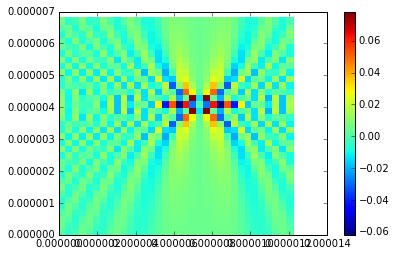

In [20]:
xx = 20
yy = 20
transmat.shape = (xN,yN,2,nelem,xN,yN,2,nelem)

%matplotlib inline
from matplotlib import pyplot as plt
#xf.shape
#f, ax = plt.subplots()
C = np.real(transmat[xx,yy,0,0,:,:,0,0])
#C = ab[:,1,1].
#C.shape=x.shape
plt.pcolormesh(x,y,C,cmap='jet'
             )
plt.colorbar()
C

array([[ 0.041438  ,  0.08183113,  0.10319499, ...,  0.10319499,
         0.08183113,  0.041438  ],
       [ 0.05271919,  0.09978364,  0.11679383, ...,  0.11679383,
         0.09978364,  0.05271919],
       [ 0.05732104,  0.10589128,  0.12557225, ...,  0.12557225,
         0.10589128,  0.05732104],
       ..., 
       [ 0.05732104,  0.10589128,  0.12557225, ...,  0.12557225,
         0.10589128,  0.05732104],
       [ 0.05271919,  0.09978364,  0.11679383, ...,  0.11679383,
         0.09978364,  0.05271919],
       [ 0.041438  ,  0.08183113,  0.10319499, ...,  0.10319499,
         0.08183113,  0.041438  ]])

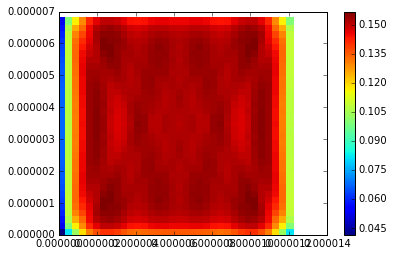

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
#xf.shape
#f, ax = plt.subplots()
C = np.imag((ab[:,0,0]+ab[:,0,2]
     ))
#C = ab[:,1,1].
C.shape=x.shape
plt.pcolormesh(x,y,C,cmap='jet'
             )
plt.colorbar()
C

In [ ]:
#Single atom near a nanoparticle, as in PRL 112, 253601. We want to reproduce part of figure 4.

#The ordering of R, r_n arguments in eq. (4) has to be checked

%matplotlib inline
import matplotlib.pyplot as plt

a = 7e-9 #7e-9
r1 = np.array([8e-9,0,0]) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array([0.19e-9*e,0,0])

R = np.array([0,1e-8,2e-9]) # detector position
#R = np.array([0,15e-8,0])
ω_0 = 3.30*eV/ℏ
Ω = ω_0+1j*γ_QE
startω = 2.7*eV/ℏ
stopω = 6.0*eV/ℏ
nmax=10

ωlist = np.linspace(startω, stopω, 300)
Slist = np.empty(shape=ωlist.shape,dtype=float)
for i in range(ωlist.shape[0]):
    ω = ωlist[i]
    ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
    k = ω/c
    k_out = math.sqrt(ε_b)*k
    k_in = cmath.sqrt(ε_m)*k
    #print ("ε_m",ε_m)
    K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)
    Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
    #pref = np.linalg.norm((ω*ω/(c*c*ε_0))*np.dot(G, μ))**2
    #postf = 1/abs(ω-Ω)**2+1/abs(ω+Ω)**2
    num = np.linalg.norm((ω*ω/(c*c*ε_0))*np.dot(K,μ))**2
    den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
           +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
    Slist[i] = num*den*2*(ω*ω+abs(Ω)**2)
plt.plot(ωlist*ℏ/eV,Slist)


In [ ]:

nmax=20
a = 7e-9 #7e-9
r1 = np.array([8e-9,0,0]) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array([0.19e-9*e,0,0])

R = np.array([0,1e-8,2e-9]) # detector position
startω = 2.7*eV/ℏ
stopω = 3.7*eV/ℏ
ωlist = np.linspace(startω, stopω, 100)
ω_0list = np.linspace(startω*1.05, stopω*0.95, 90)
Slist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Klist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Kselflist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
for i in range(ω_0list.shape[0]):
    ω_0 = ω_0list[i]
    Ω = ω_0+1j*γ_QE
    for j in range(ωlist.shape[0]):
        ω = ωlist[j]
        ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
        k = ω/c
        k_out = math.sqrt(ε_b)*k
        k_in = cmath.sqrt(ε_m)*k
        #print ("ε_m",ε_m)
        K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        num = np.linalg.norm((ω*ω/(c*c*ε_0))*np.dot(K,μ))**2
        den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
           +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
        Slist[j,i] = num/den*2*(ω*ω+abs(Ω)**2)
        #Slist[k,i] = pref*postf
        

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
%matplotlib inline
plt.imshow(Slist, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

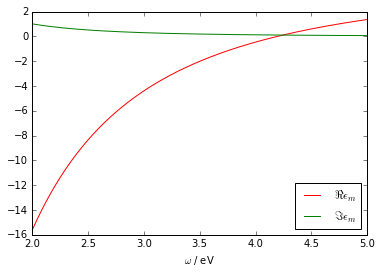

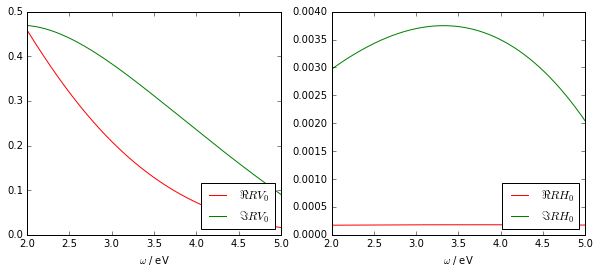

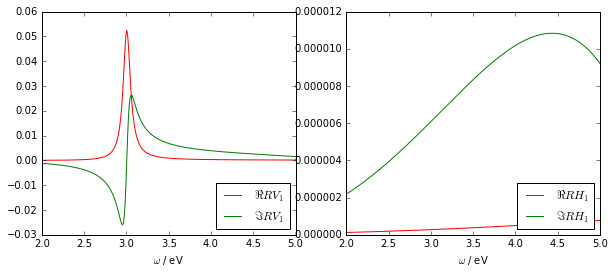

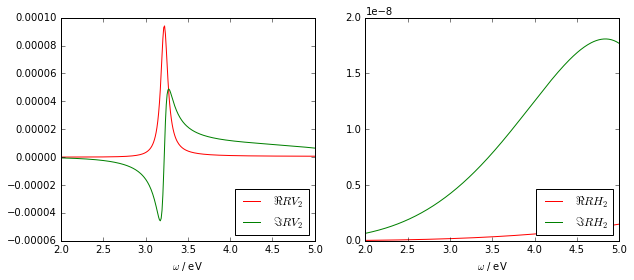

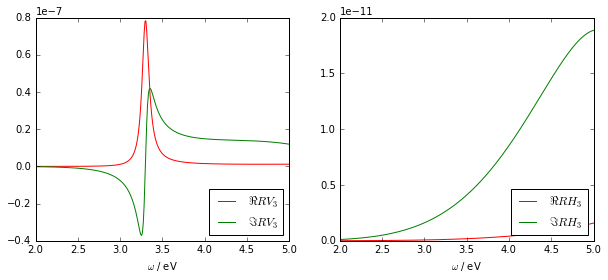

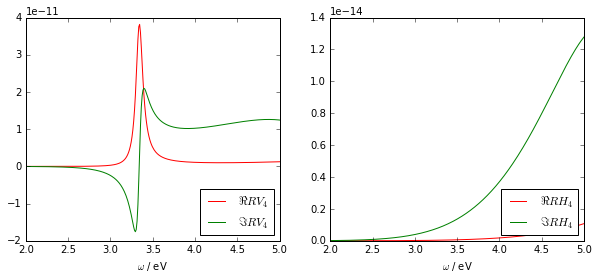

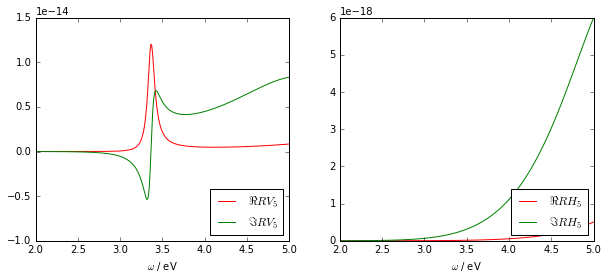

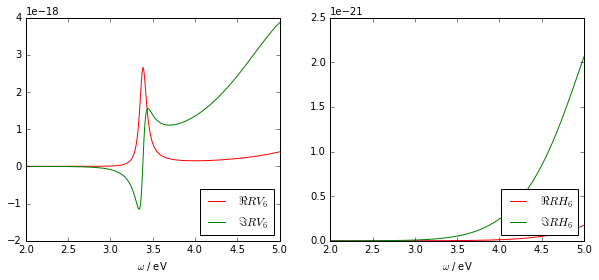

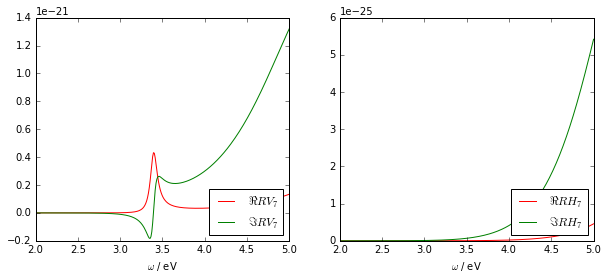

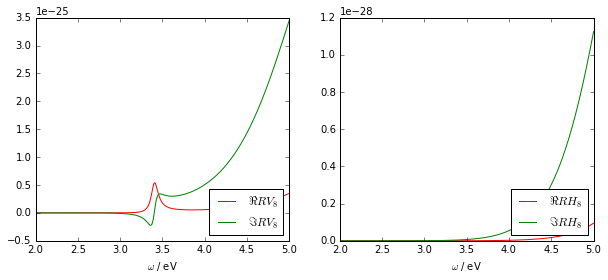

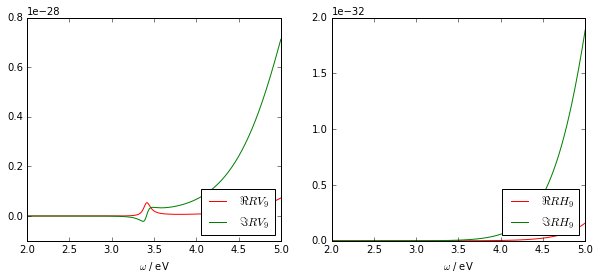

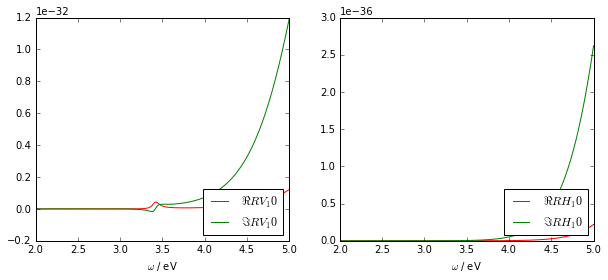

In [49]:
# Test of Mie reflection coefficients

startω =2.0*eV/ℏ
stopω = 5*eV/ℏ
ωlist = np.linspace(startω, stopω, 300)

R = 7e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
nmax = 10


from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

ε_mlist = ε_drude(ε_inf, ω_p, γ_p, ωlist)
f, ax = plt.subplots()
ax.plot(ωlist/(eV/ℏ), (np.real(ε_mlist)), 'r-', 
         label="$\Re{} \epsilon_m$")
ax.plot(ωlist/(eV/ℏ), (np.imag(ε_mlist)), 'g-',
         label="$\Im{} \epsilon_m$")
ax.set_xlabel("$\omega$ / eV")
ax.legend(loc=4)
pp.savefig()

RVlist = np.empty((nmax+1,)+ωlist.shape,dtype=np.complex_)
RHlist = np.empty((nmax+1,)+ωlist.shape,dtype=np.complex_)

for i in range(len(ωlist)):
    ω=ωlist[i]
    k_i = cmath.sqrt(ε_mlist[i])*ω/c
    k_e = cmath.sqrt(ε_b)*ω/c
    RH, RV, TH, TV = mie_coefficients(a=a, nmax=nmax, k_i=k_i, k_e=k_e, J_ext=1, J_scat=3)
    RVlist[:,i] = RV
    RHlist[:,i] = RH

ε_mlist = ε_drude(ε_inf, ω_p, γ_p, ωlist)

for n in range(nmax+1):
    f, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(ωlist/(eV/ℏ), (np.real(RVlist[n])), 'r-', 
             label="$\Re{} RV_"+str(n)+"$")
    ax[0].plot(ωlist/(eV/ℏ), (np.imag(RVlist[n])), 'g-',
             label="$\Im{} RV_"+str(n)+"$")
    ax[1].plot(ωlist/(eV/ℏ), (np.real(RHlist[n])), 'r-', 
             label="$\Re{} RH_"+str(n)+"$")
    ax[1].plot(ωlist/(eV/ℏ), (np.imag(RHlist[n])), 'g-',
             label="$\Im{} RH_"+str(n)+"$")

    ax[0].set_xlabel("$\omega$ / eV")
    ax[1].set_xlabel("$\omega$ / eV")
    ax[0].legend(loc=4)
    ax[1].legend(loc=4)
    pp.savefig()

pp.close()